In [1]:
from tqdm import tqdm
import numpy as np
import os
from nilearn.image import load_img
from rsatoolbox.util.searchlight import get_volume_searchlight
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import mc
import pickle
import sys
from datetime import date
import json
from fnmatch import fnmatch



In [34]:
# helper functions

def pair_correct_tasks(data_dict, keys_list):
    """
    data_dict: dict with keys like 'A1_forw_A_reward'
    keys_list: ordered list of keys you want to include and in what order
    Returns two matrices: one for the first element of each pair, one for its match.
    """
    # Define task pairing relationships
    task_pairs = {'1_forw': '2_backw', '1_backw': '2_forw'}
    th_1, th_2, paired_list_control  = [], [], []
    # Loop through keys in the *specified order*
    for key in keys_list:
        assert key in data_dict, "Missmatch between model rdm keys and data RDM keys"
        task, direction, state, phase = key.split('_')  # e.g. ['A1', 'forw', 'A', 'reward']
        # Create the pairing suffix (e.g. from '1_forw' → '2_backw')
        pair_suffix = task_pairs.get(f"{task[-1]}_{direction}")
        # Build the paired key (e.g. 'A2_backw_A_reward')
        pair_key = f"{task[0]}{pair_suffix}_{state}_{phase}"
        # Only add if both keys exist
        if pair_key in data_dict:
            th_1.append(np.asarray(data_dict[key]))
            th_2.append(np.asarray(data_dict[pair_key]))
            paired_list_control.append(f"{key} with {pair_key}")

    # import pdb; pdb.set_trace()       
    th_1 = np.vstack(th_1)
    th_2 = np.vstack(th_2)
    # print(paired_list_control)
    return th_1, th_2, paired_list_control



import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

def vec_to_mat(vec):
    L = len(vec)
    n = int((np.sqrt(8 * L + 1) - 1) / 2)
    M = np.full((n, n), np.nan, dtype=float)
    M[np.triu_indices(n, k=0)] = vec
    return M

def parse_paired_label(lbl: str):
    left, right = lbl.split(" with ")
    l = left.split("_")
    r = right.split("_")
    arrow = {"backw": "←", "forw": "→"}
    block = f"{l[0]}{arrow.get(l[1], '')}|{r[0]}{arrow.get(r[1], '')}"  # compact
    within = f"{l[2]}-{l[3]}".replace("reward", "rew")
    return block, within

def plot_rdm_upper(
    rdm_flat,
    paired_labels,
    title="RDM",
    block_size=8,
    cmap="RdBu",
    vmin=0, vmax=2,
    gamma=None,                 # e.g. 0.7 for more contrast in mid/high range
    show_within_key=True,
    label_fontsize=10,
    figsize=(4.2, 4.2)
):
    M = vec_to_mat(rdm_flat)
    n = M.shape[0]

    # make NaNs white
    cmap_obj = plt.get_cmap(cmap).copy()
    cmap_obj.set_bad("white")
    Mmask = np.ma.masked_invalid(M)

    norm = (mpl.colors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
            if gamma is not None else
            mpl.colors.Normalize(vmin=vmin, vmax=vmax))

    fig, ax = plt.subplots(figsize=figsize, constrained_layout=False)
    im = ax.imshow(Mmask, cmap=cmap_obj, norm=norm, interpolation="None", aspect="equal")

    # block separators
    for b in range(block_size, n, block_size):
        ax.axhline(b - 0.5, color="white", lw=1.2)
        ax.axvline(b - 0.5, color="white", lw=1.2)

    # hierarchical block labels (one per 8)
    parsed = [parse_paired_label(l) for l in paired_labels]
    block_labels = [parsed[i][0] for i in range(0, n, block_size)]
    centers = np.arange(block_size / 2 - 0.5, n, block_size)

    ax.set_xticks([])  # usually drop x labels for small figs
    ax.set_yticks(centers)
    ax.set_yticklabels(block_labels, fontsize=label_fontsize)

    # y labels on the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(length=0, pad=1)

    ax.set_title(title, fontsize=label_fontsize + 2)

    if show_within_key:
        within = [parsed[i][1] for i in range(0, block_size)]
        ax.set_xlabel("Within-block: " + " | ".join(within), fontsize=label_fontsize - 1, labelpad=6)

    # colorbar on the left (robust way)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="4%", pad=0.08)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.tick_params(labelsize=label_fontsize)
    

    return fig, ax




def plot_3_rdms(
    rdms_flat,              # list/tuple of 3 flattened vectors
    paired_labels,          # length n (e.g. 80)
    titles=("RDM 1", "RDM 2", "RDM 3"),
    block_size=8,
    cmap="magma",
    vmin=0, vmax=2,
    gamma=None,             # e.g. 0.8 for more contrast
    draw_diag=False,
    figsize=(12, 4.2),
    label_fontsize=9,
    show_block_labels="rightmost",  # "rightmost" | "all" | "none"
    show_within_key=True,
):
    assert len(rdms_flat) == 3, "Pass exactly three RDM vectors."

    Ms = []
    for vec in rdms_flat:
        M = vec_to_mat(vec)
        if not draw_diag:
            np.fill_diagonal(M, np.nan)
        Ms.append(M)

    n = Ms[0].shape[0]
    if any(M.shape != (n, n) for M in Ms):
        raise ValueError("All three RDMs must have the same inferred size.")
    if len(paired_labels) != n:
        raise ValueError(f"len(paired_labels)={len(paired_labels)} but RDM is {n}x{n}.")

    # NaNs -> white
    cmap_obj = plt.get_cmap(cmap).copy()
    cmap_obj.set_bad("white")

    # shared norm
    norm = (mpl.colors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
            if gamma is not None else
            mpl.colors.Normalize(vmin=vmin, vmax=vmax))

    # parse labels once
    parsed = [parse_paired_label(l) for l in paired_labels]
    block_labels = [parsed[i][0] for i in range(0, n, block_size)]
    centers = np.arange(block_size/2 - 0.5, n, block_size)

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    fig.subplots_adjust(left=0.10, right=0.98, bottom=0.18, top=0.86, wspace=0.08)

    last_im = None
    for i, ax in enumerate(axs):
        Mmask = np.ma.masked_invalid(Ms[i])
        last_im = ax.imshow(Mmask, cmap=cmap_obj, norm=norm, interpolation="nearest", aspect="equal")
        ax.set_facecolor("white")

        # block separators
        for b in range(block_size, n, block_size):
            ax.axhline(b - 0.5, color="white", lw=1.2)
            ax.axvline(b - 0.5, color="white", lw=1.2)

        ax.set_title(titles[i], fontsize=label_fontsize + 2)
        ax.set_xticks([])

        # y labels on the right (only where requested)
        do_y = (show_block_labels == "all") or (show_block_labels == "rightmost" and i == 2)
        if do_y:
            ax.set_yticks(centers)
            ax.set_yticklabels(block_labels, fontsize=label_fontsize)
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
        else:
            ax.set_yticks([])

        ax.tick_params(length=0, pad=1)

    # single colorbar on the LEFT
    cax = fig.add_axes([0.04, 0.25, 0.012, 0.55])  # [left, bottom, width, height]
    cbar = fig.colorbar(last_im, cax=cax)
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.tick_params(labelsize=label_fontsize)

    # single within-block description
    if show_within_key:
        within = [parsed[i][1] for i in range(0, block_size)]
        fig.text(
            0.52, 0.08,
            "Within-block order (repeats every 8): " + " | ".join(within),
            ha="center", va="center", fontsize=label_fontsize
        )

    return fig, axs




In [3]:
# load data and configs.
# import pdb; pdb.set_trace() 
source_dir = "/Users/xpsy1114/Documents/projects/multiple_clocks"
config_path = f"{source_dir}/multiple_clocks_repo/condition_files"
print("Running on laptop.")
      

# --- Load configuration ---
# config_file = sys.argv[2] if len(sys.argv) > 2 else "rsa_config_simple.json"
config_file = "rsa_config_state_and_combostate-pathandrew.json"
with open(f"{config_path}/{config_file}", "r") as f:
    config = json.load(f)

# SETTINGS
EV_string = config.get("load_EVs_from")
regression_version = config.get("regression_version")
today_str = date.today().strftime("%d-%m-%Y")
name_RSA = config.get("name_of_RSA")
RDM_version = f"{name_RSA}_{today_str}"

# Subjects
subj_no = '02'  
subjects = [f"sub-{subj_no}"]

# Flags
smoothing = config.get("smoothing", True)
fwhm = config.get("fwhm", 5)
load_searchlights = config.get("load_searchlights", False)
masked_conditions = config.get("masked_conds", None)

# conditions selection
conditions = config.get("EV_condition_selection")
parts_to_use = conditions["parts"]



Running on laptop.


loaded the following data EVs in dict: ['A1_backw_A_path', 'A1_backw_A_reward', 'A1_backw_B_path', 'A1_backw_B_reward', 'A1_backw_C_path', 'A1_backw_C_reward', 'A1_backw_D_path', 'A1_backw_D_reward', 'A1_forw_A_path', 'A1_forw_A_reward', 'A1_forw_B_path', 'A1_forw_B_reward', 'A1_forw_C_path', 'A1_forw_C_reward', 'A1_forw_D_path', 'A1_forw_D_reward', 'B1_backw_A_path', 'B1_backw_A_reward', 'B1_backw_B_path', 'B1_backw_B_reward', 'B1_backw_C_path', 'B1_backw_C_reward', 'B1_backw_D_path', 'B1_backw_D_reward', 'B1_forw_A_path', 'B1_forw_A_reward', 'B1_forw_B_path', 'B1_forw_B_reward', 'B1_forw_C_path', 'B1_forw_C_reward', 'B1_forw_D_path', 'B1_forw_D_reward', 'C1_backw_A_path', 'C1_backw_A_reward', 'C1_backw_B_path', 'C1_backw_B_reward', 'C1_backw_C_path', 'C1_backw_C_reward', 'C1_backw_D_path', 'C1_backw_D_reward', 'C1_forw_A_path', 'C1_forw_A_reward', 'C1_forw_B_path', 'C1_forw_B_reward', 'C1_forw_C_path', 'C1_forw_C_reward', 'C1_forw_D_path', 'C1_forw_D_reward', 'D1_backw_A_path', 'D1_b

/Users/xpsy1114/Documents/projects/multiple_clocks/multiple_clocks_repo/mc/analyse/my_RSA.py:268: RuntimeWarning: invalid value encountered in divide
  data_demeaned /= np.sqrt(np.einsum('ij,ij->i', data_demeaned, data_demeaned))[:, None]


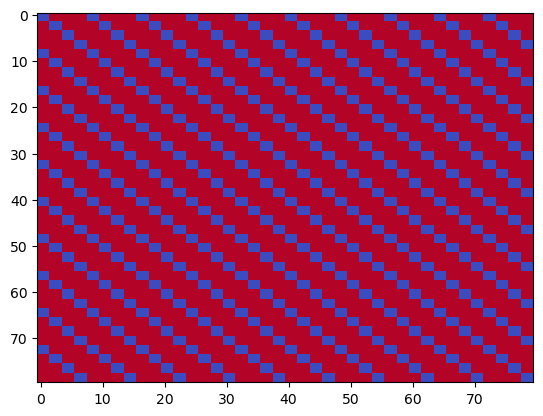

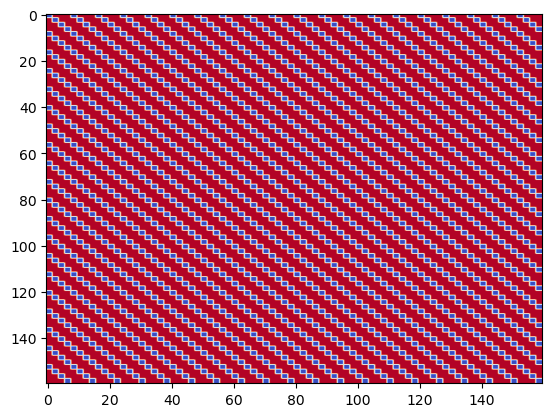

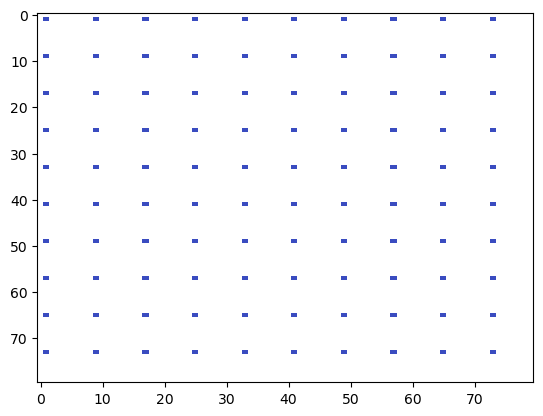

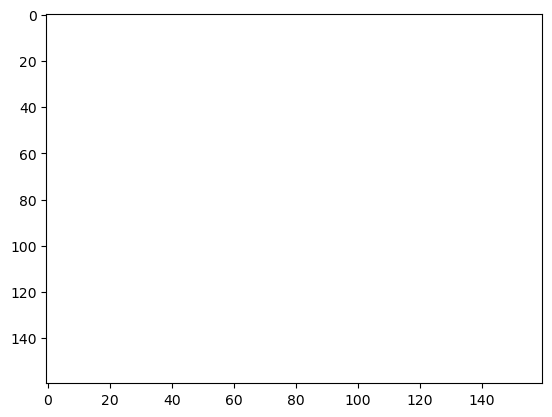

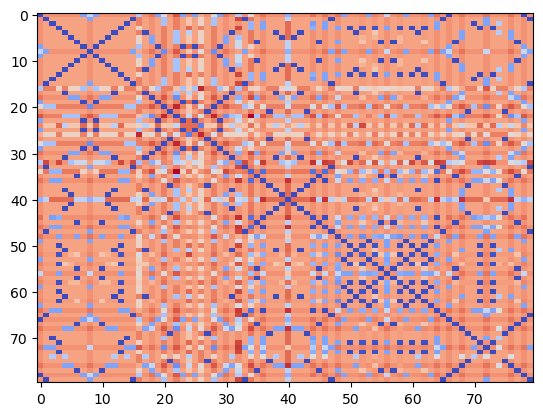

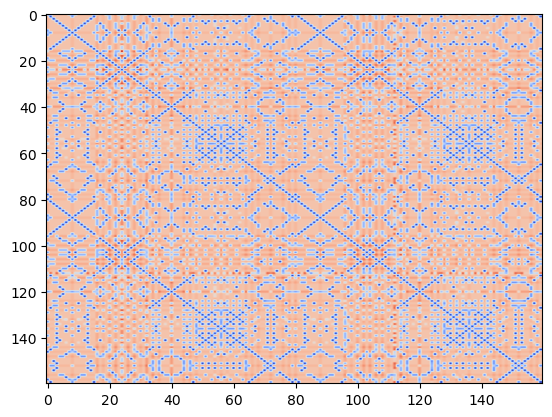

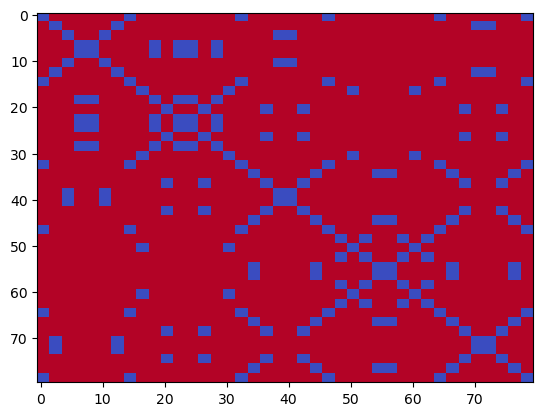

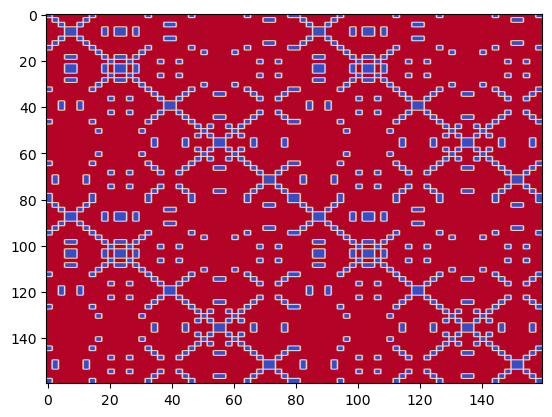

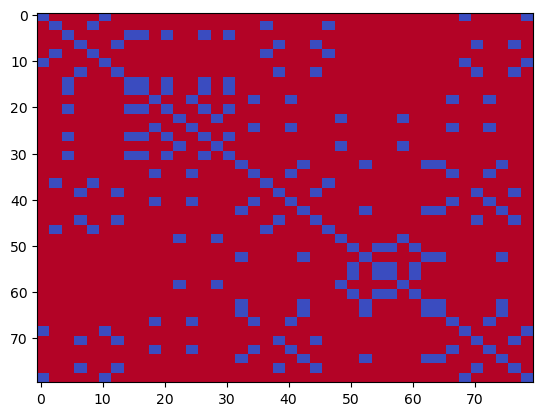

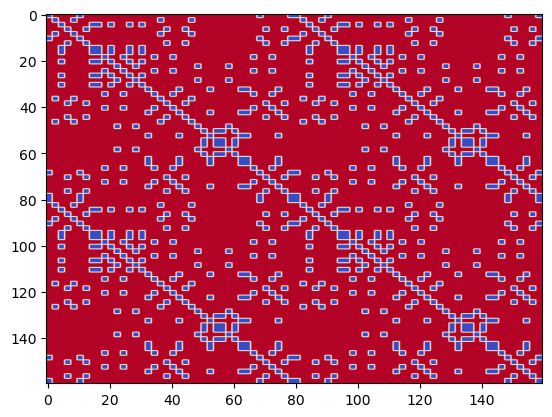

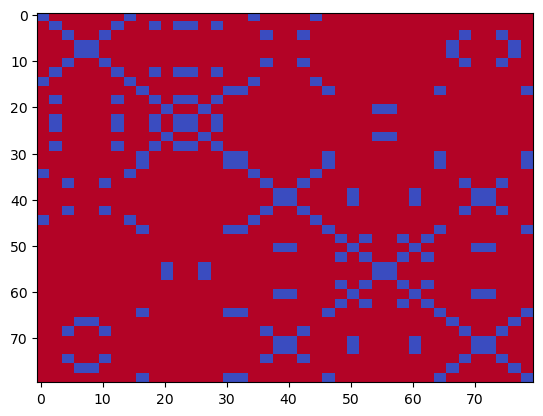

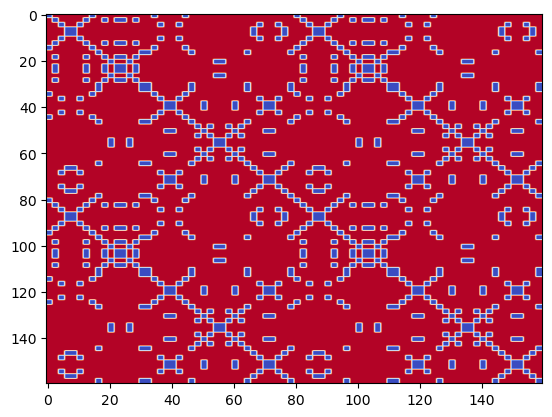

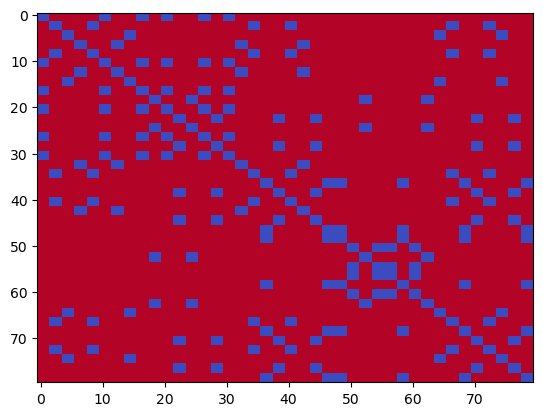

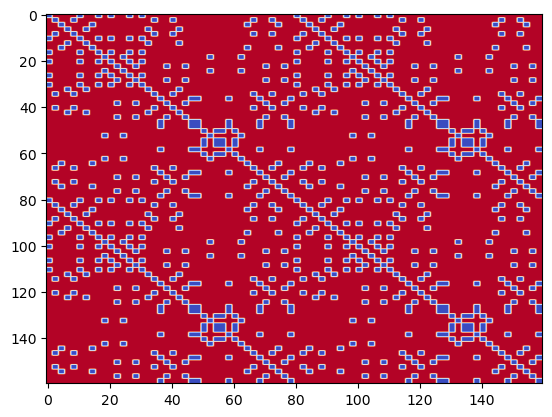

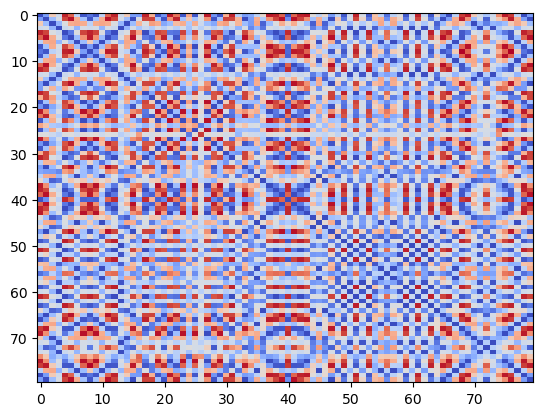

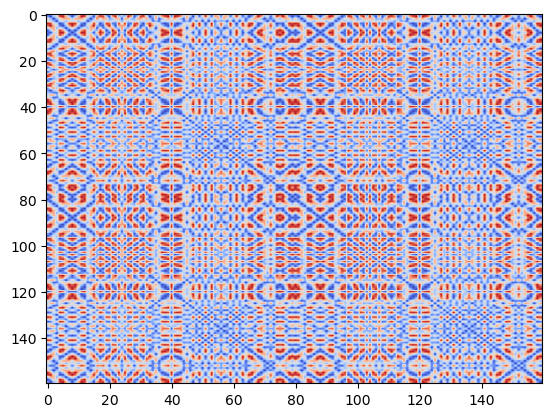

In [4]:
for sub in subjects:
    data_dir = f"/Users/xpsy1114/Documents/projects/multiple_clocks/data/derivatives/{sub}"
    
    modelled_conditions_dir = f"{data_dir}/beh/modelled_EVs"
    data_rdm_dir = f"{data_dir}/func/data_RDMs_{RDM_version}_glmbase_{regression_version}"

    results_dir = f"{data_dir}/func/RSA_{RDM_version}_glmbase_{regression_version}/results" 
    if smoothing == True:
       results_dir = f"{data_dir}/func/RSA_{RDM_version}_glmbase_{regression_version}_smooth{fwhm}/results" 
    os.makedirs(results_dir, exist_ok=True)

    if masked_conditions:
        if masked_conditions[0] == 'load_same_loc_instate_mask':
            with open (f"{data_dir}/{masked_conditions[1]}", "r") as f:
                json_mask = json.load(f)
            masked_conditions = json_mask.get("masked_conditions")
        
        
    # loading the model EVs into dict
    with open(f"{modelled_conditions_dir}/{sub}_modelled_EVs_{EV_string}.pkl", 'rb') as file:
        model_EVs = pickle.load(file)
        
    selected_models = config.get("models", list(model_EVs.keys()))
    # loading the data EVs into dict
    data_EVs, all_EV_keys = mc.analyse.my_RSA.load_data_EVs(data_dir, regression_version=regression_version, only_load_labels = True)
    
    # if you don't want all conditions created through FSL, exclude some here!
    # based on config file:
    # Ensure all four parts exist in config
    for _p in ("task", "direction", "state", "phase"):
        if _p not in parts_to_use:
            raise ValueError(f"Missing selection.parts['{_p}'] in config.")
            
    EV_keys = []        
    for ev in sorted(all_EV_keys):
        task, direction, state, phase = ev.split('_')
        # simple include/exclude logic
        for name, value in zip(["task", "direction", "state", "phase"], [task, direction, state, phase]):
            part = parts_to_use[name]
            includes = part.get("include", [])
            excludes = part.get("exclude", [])
            # Exclude first
            if any(fnmatch(value, pat) for pat in excludes):
                break  
            # If include list non-empty → must match at least one
            if includes and not any(fnmatch(value, pat) for pat in includes):
                break
        else:
            # only append if none of the 4 parts triggered 'break'
            EV_keys.append(ev)
    print(f"including the following EVs in the RDMs: {EV_keys}")
    # data_th1, data_th2, paired_labels = pair_correct_tasks(EV_keys, EV_keys)
    data_th1, data_th2, paired_labels = pair_correct_tasks(data_EVs, EV_keys)
    data_concat = np.concatenate((data_th1, data_th2), axis = 0)
    # 
    # Step 3: compute the model and data RDMs.
    models_concat = {}
    model_RDM_dir = {}
    
    for model in model_EVs:
        model_th1, model_th2, model_paired_labels = pair_correct_tasks(model_EVs[model], EV_keys)
        # finally, concatenate th1 and th2 to do the cross-correlation after
        models_concat[model] = np.concatenate((model_th1, model_th2), axis = 0)
        
        if masked_conditions:
            # here, I want to now mask all within-task similarities.
            model_RDM_dir[model] = mc.analyse.my_RSA.compute_crosscorr_and_filter(models_concat[model], plotting = False, labels = model_paired_labels, mask_pairs= masked_conditions, full_mask=None, binarise = False)
            print(f"excluding n = {np.sum(np.isnan(model_RDM_dir[model]))} datapoints from {len(model_RDM_dir[model][0])}.")
            # import pdb; pdb.set_trace()
        else:  
            model_RDM_dir[model] = mc.analyse.my_RSA.compute_crosscorr(models_concat[model], plotting= True)
            if model == 'A-state':
                A_state_mask = ~np.isnan(model_RDM_dir['A-state'][0])
                # import pdb; pdb.set_trace()
                # first make sure to not do this for the 'correct nans'
                nan_mask = np.isnan(model_RDM_dir['state'][0])
                # then turn all nans into 1s
                nan_mask_other_states = np.isnan(model_RDM_dir[model][0])
                model_RDM_dir[model][0][nan_mask_other_states] = 1
                #plt.figure(); plt.imshow(model_RDM_dir[model][0])
    
    if 'A-state-ones' in selected_models:
        model_RDM_dir['state'][0][A_state_mask] = model_RDM_dir['state'][0][3]
        print(f"set state A in state regressor to {model_RDM_dir['state'][0][3]}")
    if 'A-state-mask' in selected_models:
        # A_state_mask = ~np.isnan(model_RDM_dir['A-state'][0])
        for model in model_RDM_dir:
            model_RDM_dir[model][0][A_state_mask] = np.nan
            print(f"excluding n = {np.sum(np.isnan(model_RDM_dir[model]))} datapoints from {len(model_RDM_dir[model][0])} because of state-A masking.")
   

    

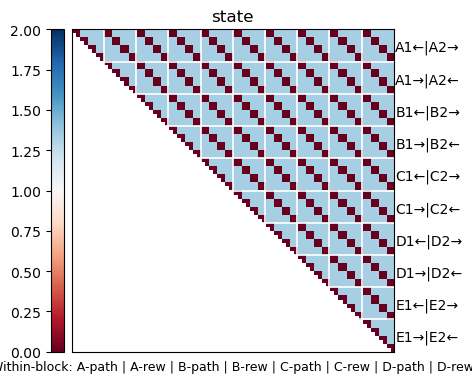

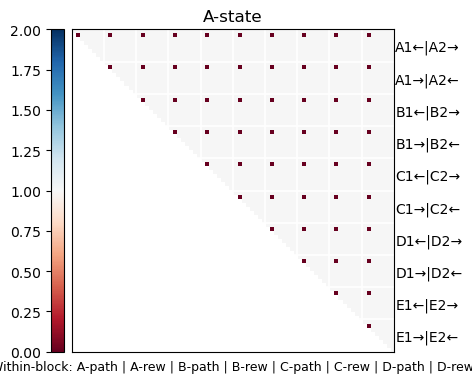

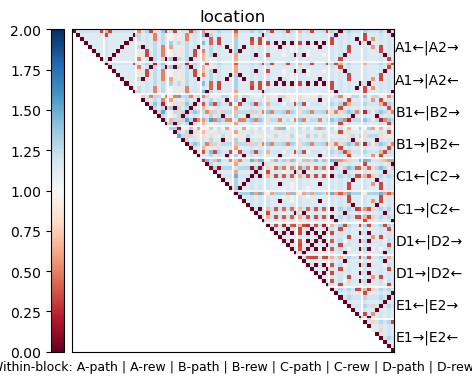

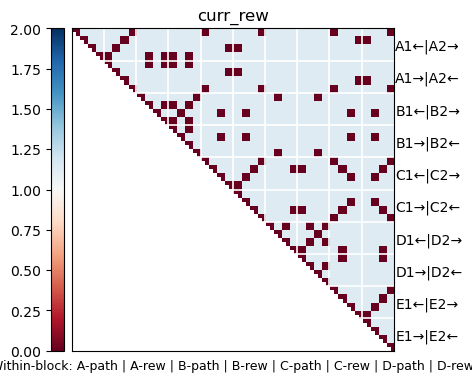

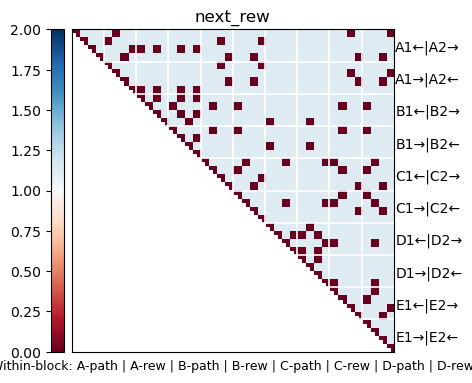

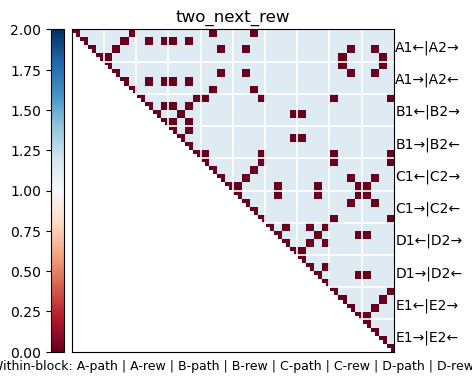

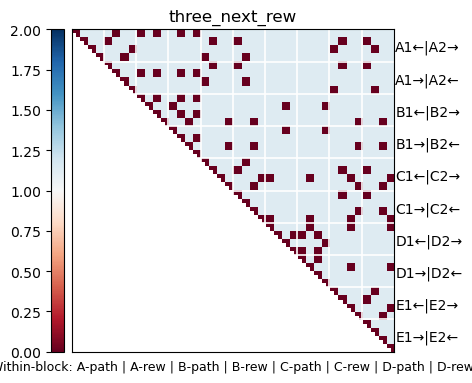

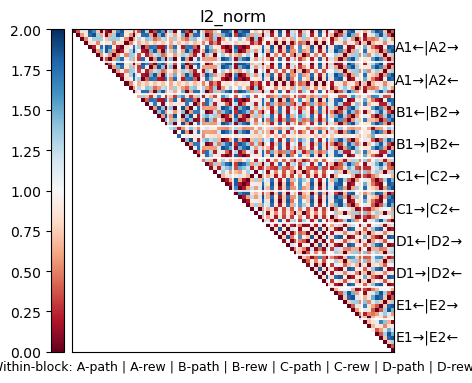

In [26]:
for name in model_RDM_dir:
    plot_rdm_upper(
        model_RDM_dir[name][0],
        paired_labels=model_paired_labels,
        title=name, save)
    
plt.show()



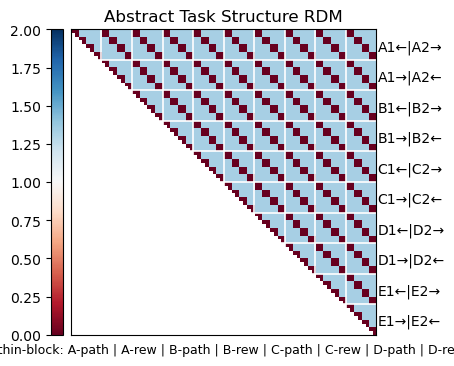

In [36]:
fig, ax = plot_rdm_upper(
        model_RDM_dir['state'][0],
        paired_labels=model_paired_labels,
        title='Abstract Task Structure RDM')
plt.show()
fig.savefig(f'{results_dir}/State_RDM.png')

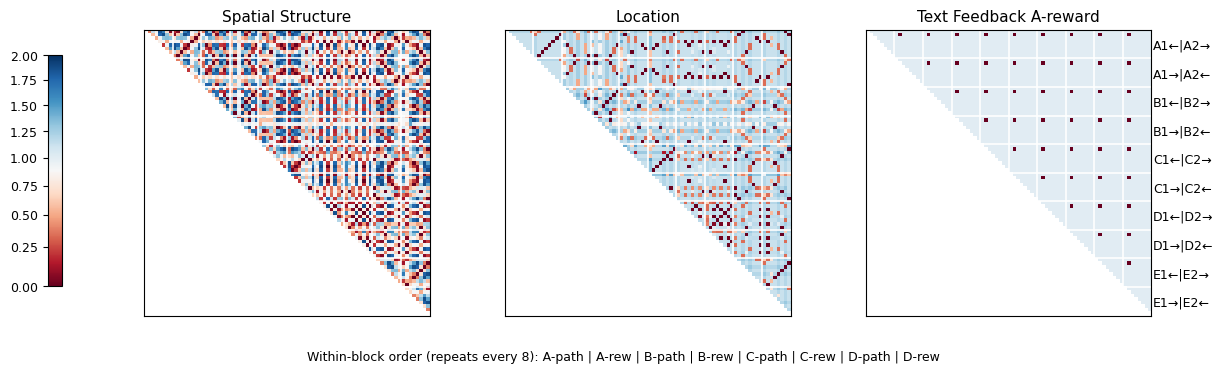

In [44]:
fig, axs = plot_3_rdms(
    [model_RDM_dir['l2_norm'][0], model_RDM_dir["location"][0], model_RDM_dir["A-state"][0]],
    paired_labels=model_paired_labels,
    titles=("Spatial Structure", "Location", "Text Feedback A-reward"),
    cmap="RdBu",   # try: "magma", "inferno", "viridis", "plasma", "turbo"
    gamma=0.85,       # boosts contrast (optional)
    vmin=0, vmax=2,
    show_block_labels="rightmost",
    show_within_key=True
)
plt.show()
fig.savefig(f'{results_dir}/Control_RDMs.png')

In [40]:
for m in model_RDM_dir:
    print(m)

state
A-state
location
curr_rew
next_rew
two_next_rew
three_next_rew
l2_norm
